In [16]:
#1. Import packages
import tensorflow as tf
import os
import random
import numpy as np
from tensorflow import keras
from tqdm import tqdm 
import cv2
from tensorflow_examples.models.pix2pix import pix2pix
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [17]:
#2. Data Loading
dataset = r"C:\Users\zahiz\Desktop\Capstone3_Nuclei\data-science-bowl-2018\dataset\data-science-bowl-2018-2"

In [ ]:
# Import necessary libraries
import tensorflow as tf

# Set image dimensions and channels
IMG_HEIGHT = 128 
IMG_WIDTH = 128   
IMG_CHANNELS = 3

# Function to parse and preprocess images
def parse_image(filename, img_height, img_width):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to parse and preprocess masks
def parse_mask(filename, img_height, img_width):
    mask = tf.io.read_file(filename)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_height, img_width])
    mask = mask / 255.0  # Normalize to [0,1]
    return mask

# Function to create a dataset with images and corresponding masks
def load_dataset(image_dir, mask_dir, img_height, img_width, batch_size=32):
    # List of sorted file paths for images and masks
    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])
    
    # Create TensorFlow datasets for images and masks
    image_ds = tf.data.Dataset.from_tensor_slices(image_files).map(
        lambda x: parse_image(x, img_height, img_width), num_parallel_calls=tf.data.AUTOTUNE)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_files).map(
        lambda x: parse_mask(x, img_height, img_width), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Combine image and mask datasets, batch, and prefetch
    dataset = tf.data.Dataset.zip((image_ds, mask_ds))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [ ]:
# Load training and testing datasets
train_dataset= load_dataset('dataset/data-science-bowl-2018-2/train/inputs', 'dataset/data-science-bowl-2018-2/train/masks', IMG_HEIGHT, IMG_WIDTH)
test_dataset = load_dataset('dataset/data-science-bowl-2018-2/test/inputs', 'dataset/data-science-bowl-2018-2/test/masks', IMG_HEIGHT, IMG_WIDTH)

In [19]:
# 5. Create a custom augmentation layer through subclassing
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [20]:
# 7. Create a function to visualize the image, label and prediction
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

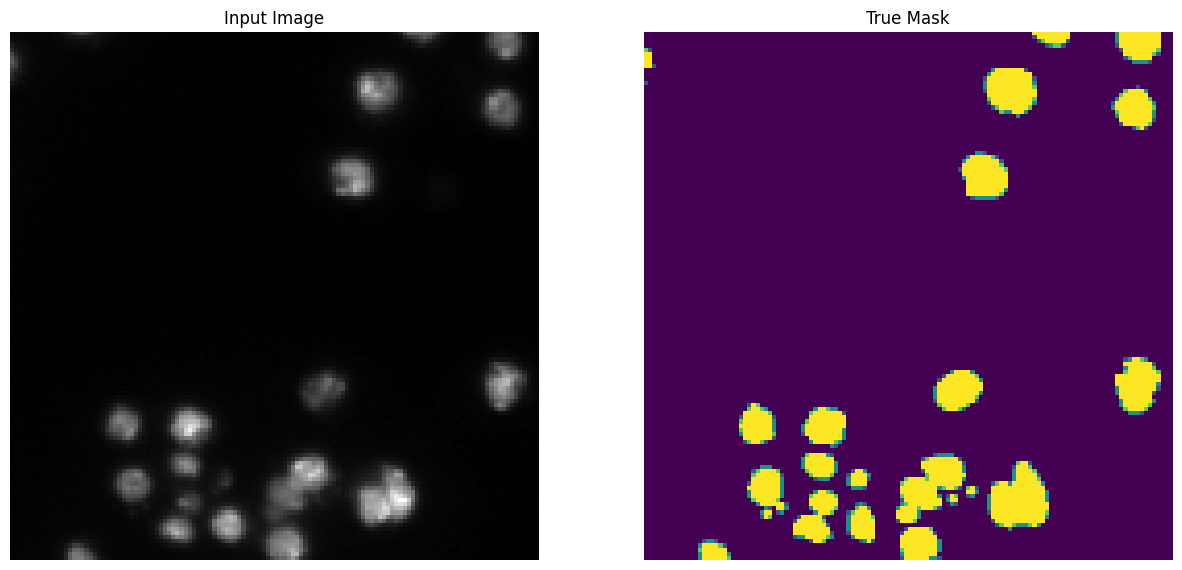

In [21]:
# Let's test out the function 
for images,labels in test_dataset.take(1):
    sample_image, sample_mask = images[0],labels[0]
    display([images[0],labels[0]])
# purple: body
# yellow: boundary 

In [22]:
images[0].shape

TensorShape([128, 128, 3])

In [23]:
# 8. Model development
# (A) Get the pretrained model as feature extractor
base_model = keras.applications.MobileNetV2(input_shape=[128,128,3],
                                            include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [24]:
# 9. Use these activations layers as the outputs of the feature extractor
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extractor model that will connect to the upsampling path later
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# Freeze the feature extractor
down_stack.trainable = False

In [25]:
# Create the upsampling layers
up_stack = [ # helps to umsample once
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8 
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

up_stack[0].summary()
# seq model containing 3 layers : conv, batch, relu

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_5              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 10. Function to construct the U-Net model architecture
def unet_model(output_channels: int):  # Specify the number of output channels
    
    # Build the model using the Functional API
    # (A) Define the input layer
    inputs = keras.layers.Input(shape=[128, 128, 3])

    # (B) Pass inputs through the downsampling feature extraction path
    skips = down_stack(inputs)
    x = skips[-1]  # Start with the deepest feature map
    skips = reversed(skips[:-1])  # Reverse the remaining layers for upsampling

    # (C) Construct the upsampling path, concatenating each upsampled layer with corresponding feature maps
    for up, skip in zip(up_stack, skips):  # Upsample and concatenate with skip connections
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # (D) Add the final transpose convolution layer to restore the original resolution
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same'
    )  # Upsample from 64x64 to 128x128
    x = last(x)  # Apply the final layer

    # Create the U-Net model with defined input and output layers
    model = keras.Model(inputs=inputs, outputs=x)
    
    return model

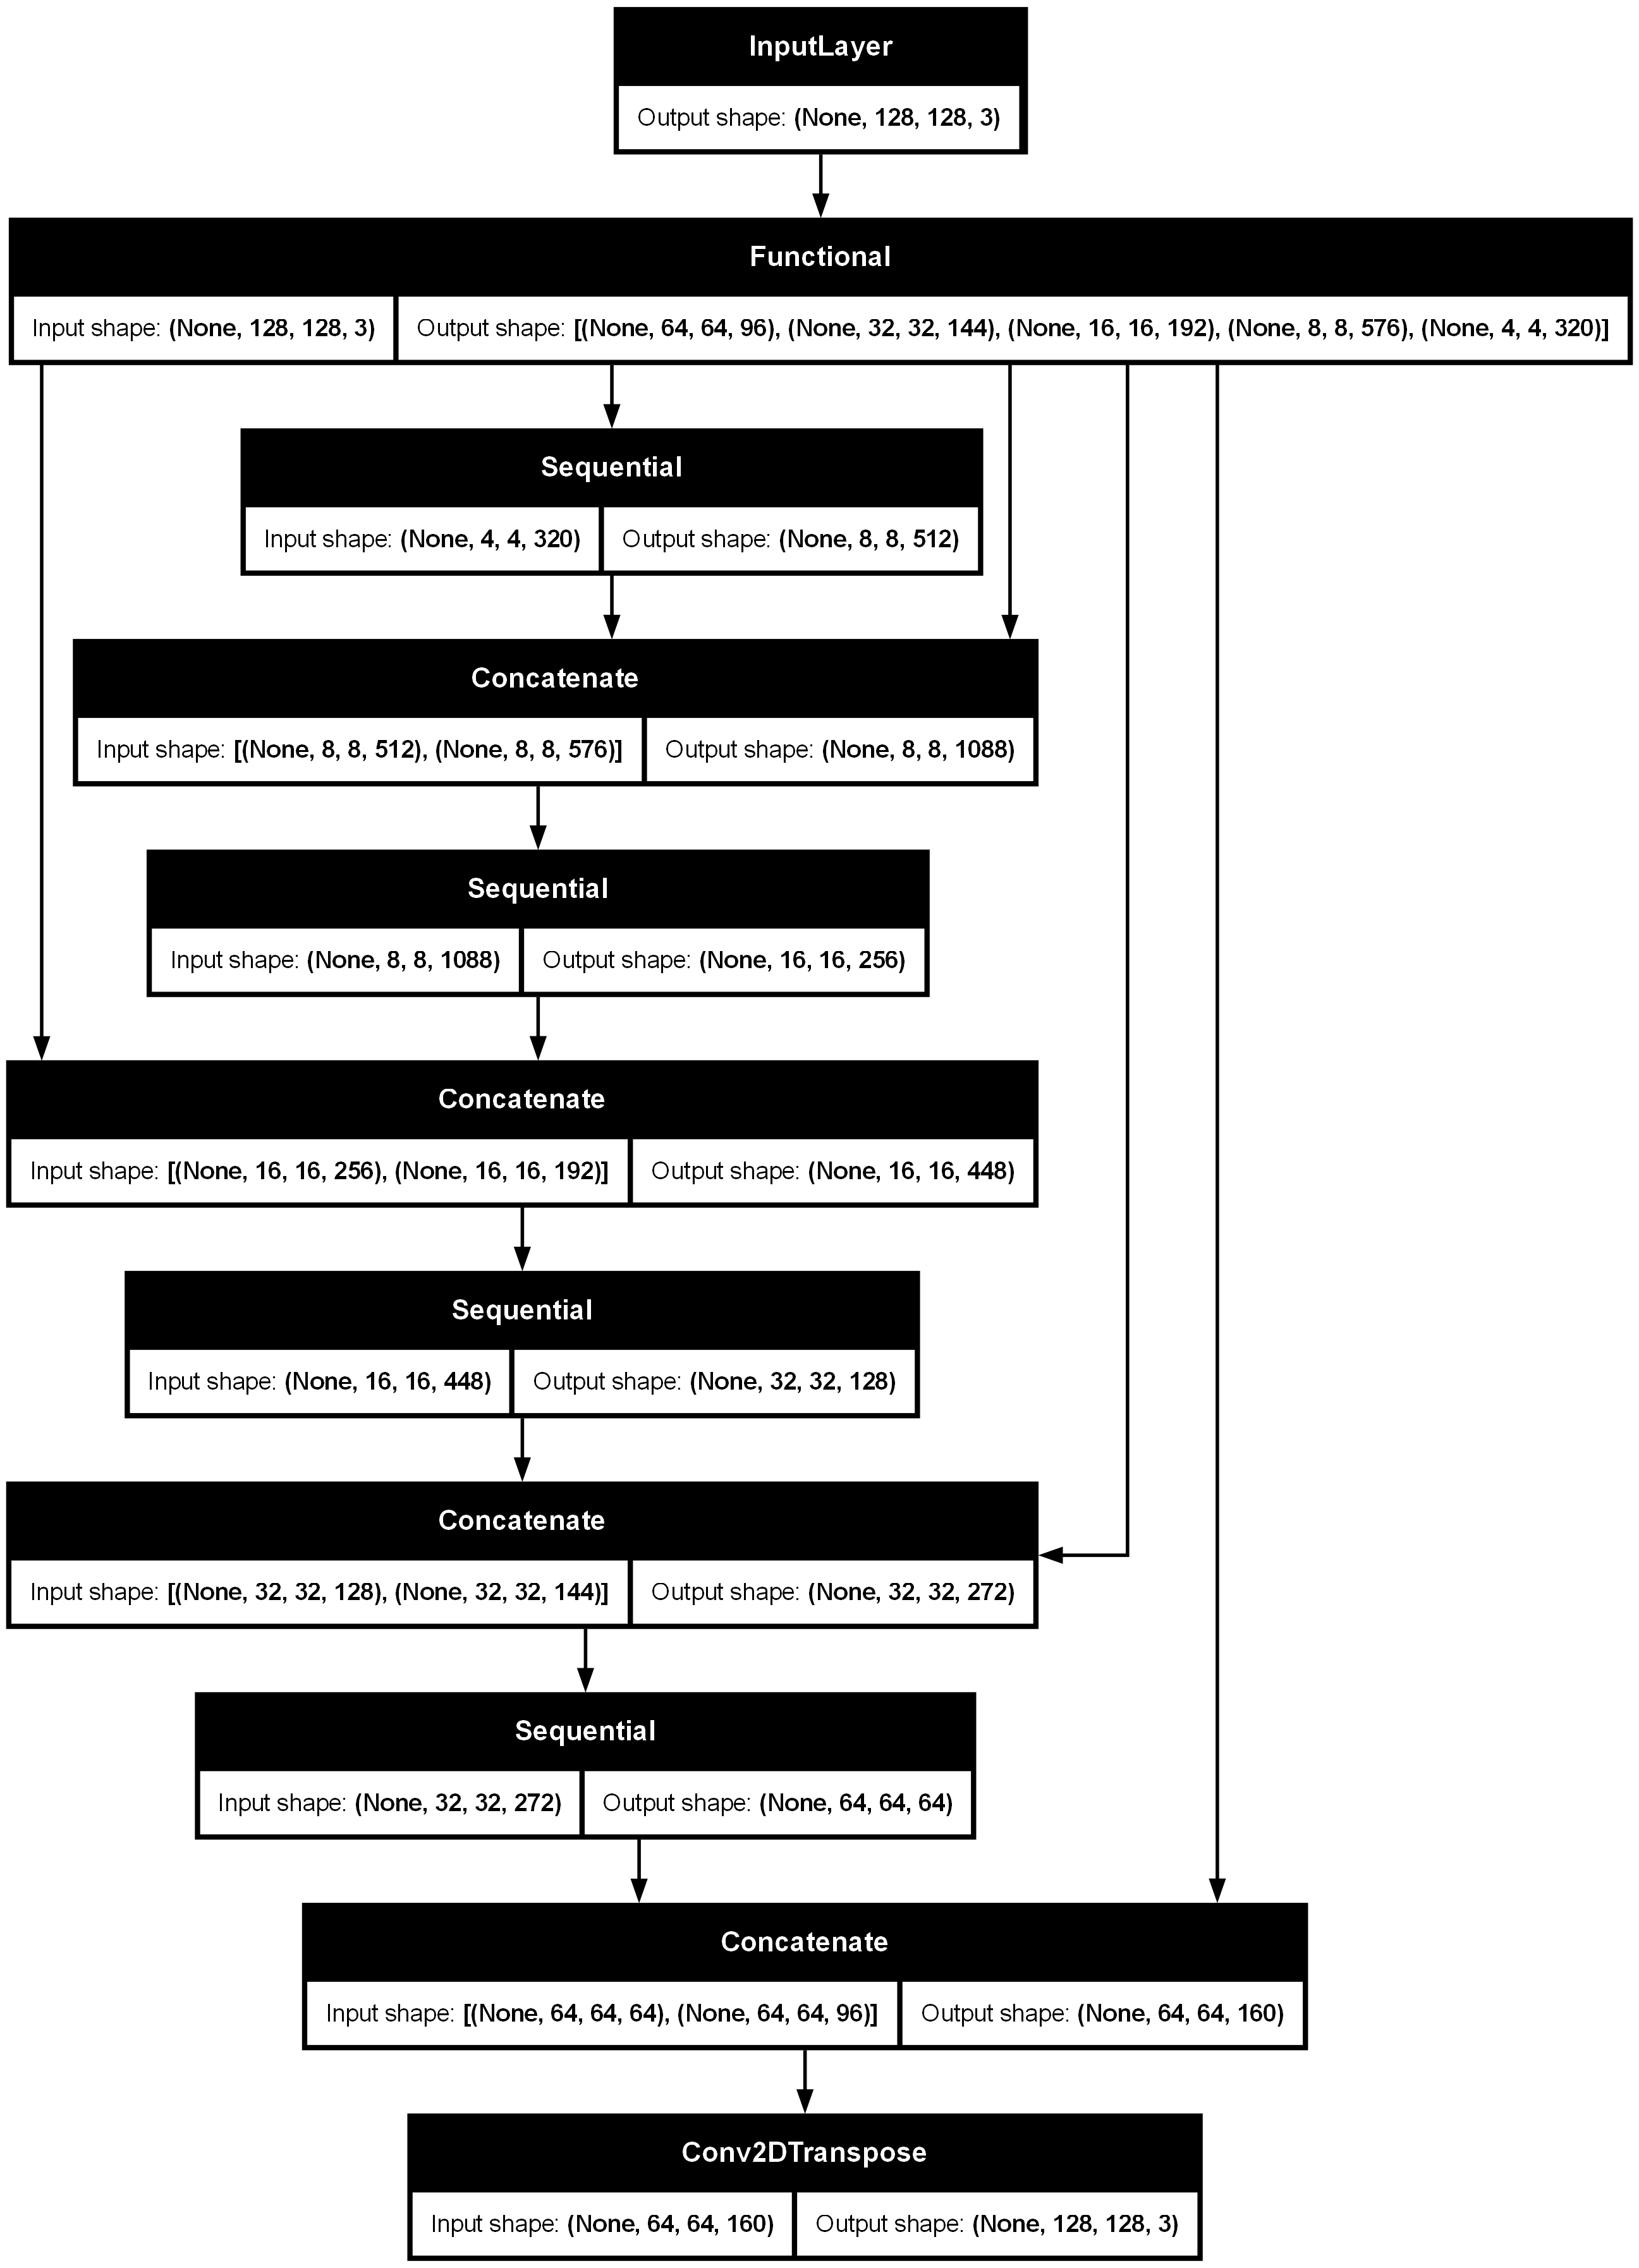

In [27]:
# 11. Use the function to create the U-Net model 
model = unet_model(3)
loss =  keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
keras.utils.plot_model(model,show_shapes=True)  

In [ ]:
# Create callbacks functions

# Function to create a mask from the predicted output
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Function to display predictions, either from a provided dataset or a sample image
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Callback class to display sample predictions at the end of each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [29]:
# Create the callbacks
import datetime,os
logpath = "tensorboard/nuclei_cell/"+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
dc = DisplayCallback()
# doesnt use es to train 10 - 20 epochs

In [30]:
# 12. Model training
EPOCHS = 15
VAL_SUBSPLITS = 5

history_first = model.fit(train_dataset, 
                          validation_data = test_dataset,
                          epochs=EPOCHS,
                          callbacks = [tb])

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.5890 - loss: 0.8004 - val_accuracy: 0.8429 - val_loss: 0.3105
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.8832 - loss: 0.2188 - val_accuracy: 0.8588 - val_loss: 0.2294
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.9216 - loss: 0.1477 - val_accuracy: 0.8659 - val_loss: 0.2092
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.9303 - loss: 0.1240 - val_accuracy: 0.8685 - val_loss: 0.2061
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.9346 - loss: 0.1136 - val_accuracy: 0.8816 - val_loss: 0.1862
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.9375 - loss: 0.1071 - val_accuracy: 0.9004 - val_loss: 0.1565
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.9392 - loss: 0.1024 - val_accuracy: 0.9159 - val_loss: 0.1327
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.9405 - loss: 0.0988 - val_accuracy: 0

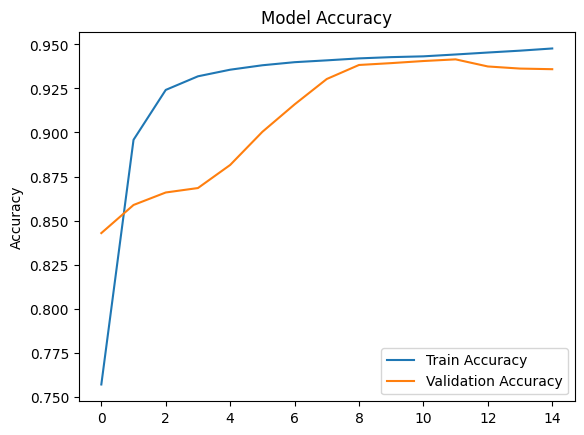

In [31]:
# Plot Accuracy Graph
plt.plot(history_first.history['accuracy'], label='Train Accuracy')
plt.plot(history_first.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.legend()  
plt.show()

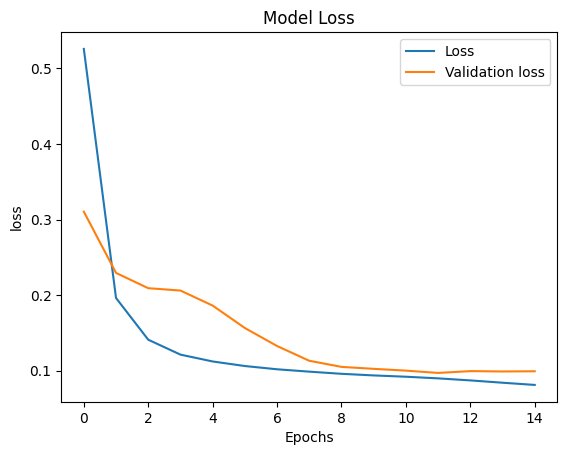

In [32]:
# Plot Loss Graph
plt.plot(history_first.history['loss'], label='Loss')
plt.plot(history_first.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


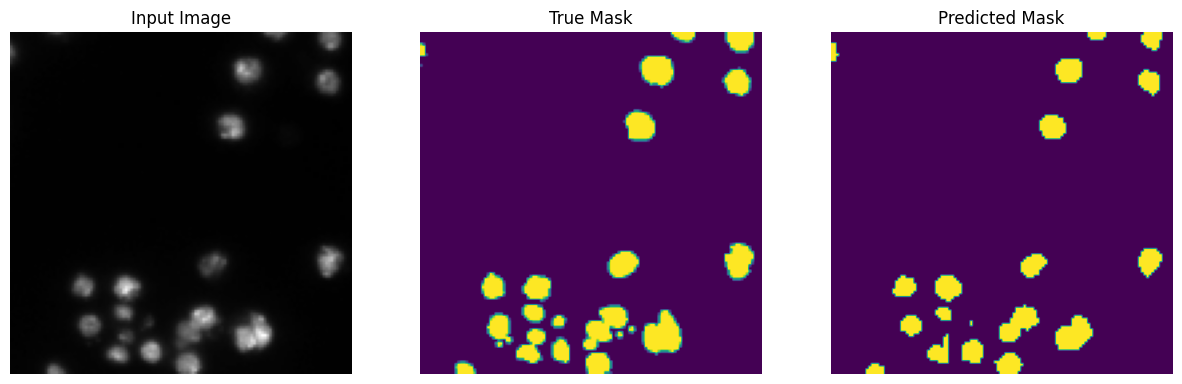

In [33]:
#13. Use model to make predictions
for test_img, test_label in test_dataset.take(1):
    predictions = model.predict(test_img)
    predictions = tf.math.argmax(predictions, axis=-1)
    predictions = tf.expand_dims(predictions, axis=-1) #expecting for 3D volume

# print(predictions[0].shape) #2D need to chanege to 3d volume
display([test_img[0], test_label[0], predictions[0]])

In [34]:
evaluation = model.evaluate(test_dataset)
# The accuracy obtained is 94%

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9369 - loss: 0.0976 


In [35]:
loss = evaluation[:1]
accuracy = evaluation[1:]
print("Loss is\n",loss)
print("Accuracy is\n",accuracy)

Loss is
 [0.09927048534154892]
Accuracy is
 [0.9359076023101807]


In [ ]:
# SAVE THE MODEL 
keras.models.save_model(model,"models/nuclei_detection.h5")